In [1]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt


from patsy import dmatrices
import bambi as bmb
import arviz as az
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import display
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set_palette('colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
def merge_crawls(crawls, all_urls):
    dfs = []

    for crawl in crawls:

        df = pd.DataFrame(columns=['file_name', 'account_name', 'url_id', 'comment_num', f'{crawl}_comments'])
        temp_list = []

        for account_name in all_urls.keys():
            files = os.listdir(f'/Users/brahmaninutakki/saarland/insta-comments/saved_data/{crawl}/{account_name}/')
            for file in files:
                with open(f'/Users/brahmaninutakki/saarland/insta-comments/saved_data/{crawl}/{account_name}/{file}', 'r') as f:
                    comments = json.load(f)

                captions = comments[0]

                if len(comments) > 2:
                    user_comment_map = {}
                    for index, val in enumerate(comments):
                        if index == 0:
                            continue

                        if val in user_comment_map.values():
                            continue
                        
                        user_comment_map[val] = comments[index + 1]

                        if comments[index + 1] == comments[-2]:
                            break

                    if 'likes' in comments[-1].lower():
                        likes = comments[-1]
                    else:
                        likes = None

                    for idx, comment in enumerate(user_comment_map.items()):

                        temp = {'file_name': file,
                                'account_name': account_name,
                                'url_id': file.split('_comments')[0],
                                'caption': captions,
                                'likes': likes,
                                'comment_num': idx,
                                f'{crawl}_comments': comment}
                        temp_list.append(temp)

                        if idx == 9:
                            break
                else:
                    temp = {'file_name': file,
                            'account_name': account_name,
                            'url_id': file.split('_comments')[0],
                            'caption': captions,
                            'likes': None,
                            'comment_num': 0,
                            f'{crawl}_comments': None}
                    temp_list.append(temp)
                

        df = pd.DataFrame(temp_list)
        dfs.append(df)
    
    for df in dfs:
        df.drop(columns=['caption', 'likes', 'file_name'], inplace=True)

    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on=['url_id', 'comment_num', 'account_name'], how='outer')

    return merged_df


def compute_fprops(merged_df, col1, col2):
    unique_files = merged_df['url_id'].unique().tolist()

    for file in unique_files:
        temp_df = merged_df[merged_df['url_id'] == file]
        s1 = temp_df[col1]
        s2 = temp_df[col2]
        fcount = (s1 == s2).value_counts().to_dict().get(False, 0)
        # fprop = fcount / temp_df.shape[0]
        merged_df.loc[merged_df['url_id'] == file, 'order_fcount'] = fcount
        merged_df.loc[merged_df['url_id'] == file, 'order_trials'] = temp_df.shape[0] 


    for file in unique_files:
        temp_df = merged_df[merged_df['url_id'] == file]
        s1 = set(temp_df[col1])
        s2 = set(temp_df[col2])
        fcount = len(s1.difference(s2))
        # fprop = fcount / temp_df.shape[0]
        merged_df.loc[merged_df['url_id'] == file, 'no_order_fcount'] = fcount
        merged_df.loc[merged_df['url_id'] == file, 'no_order_trials'] = temp_df.shape[0]


    return merged_df


def get_mat_rank(formula, data):
    y, X = dmatrices(formula, data=data, return_type='dataframe')
    return np.linalg.matrix_rank(X.values) < X.shape[1]


def get_vif(formula, data):
    y, X = dmatrices(formula, data=data, return_type="dataframe")

    vif_df = pd.DataFrame({
        "feature": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })

    vif_df.sort_values(by='VIF', ascending=True, inplace=True)
    return vif_df

In [3]:
msnbc_urls = [
    "https://www.instagram.com/msnbc/reel/DQz6GiKkqD-/",
    "https://www.instagram.com/msnbc/reel/DQzvigyiu3R/",
    "https://www.instagram.com/msnbc/reel/DQzaxBeisq2/",
    "https://www.instagram.com/msnbc/reel/DQzOhJyil7B/",
    "https://www.instagram.com/msnbc/reel/DQx_MsXDdqz/",
    "https://www.instagram.com/reel/DQx6d6TDFvD/",
    "https://www.instagram.com/reel/DQxz17nkXAu/",
    "https://www.instagram.com/reel/DQxxwsjEQxy/",
    "https://www.instagram.com/reel/DQxf5uvERD0/",
    "https://www.instagram.com/reel/DQxc21kkqwR/",
]

huffpost_urls = [
    "https://www.instagram.com/huffpost/reel/DQzSuMQARR0/",
    "https://www.instagram.com/huffpost/p/DQxLW-PEns-/",
    "https://www.instagram.com/huffpost/reel/DQxARFuAbt-/",
    "https://www.instagram.com/huffpost/reel/DQw6Qa_kWgY/",
    "https://www.instagram.com/huffpost/reel/DQw5_xHkWod/",
    "https://www.instagram.com/huffpost/reel/DQwbCxQjQNQ/",
    "https://www.instagram.com/huffpost/p/DQu2w59E9t-/",
    "https://www.instagram.com/huffpost/reel/DQvEm2FDCmz/",
    "https://www.instagram.com/huffpost/p/DQuw7U7D322/",
    "https://www.instagram.com/p/DQujjUrk61E/"
]

cnn_urls = [
    "https://www.instagram.com/reel/DQ0VgDjjx7K/",
    "https://www.instagram.com/p/DQ0LWj6jue3/",
    "https://www.instagram.com/reel/DQz7vqJiEUj/",
    "https://www.instagram.com/reel/DQznNr7gp1F/",
    "https://www.instagram.com/reel/DQzgXgPgPmN/",
    "https://www.instagram.com/reel/DQzNYM8ARN3/",
    "https://www.instagram.com/reel/DQzEp0pChCY/",
    "https://www.instagram.com/reel/DQy-AdiCcH_/",
    "https://www.instagram.com/reel/DQyzpQVjga4/",
    "https://www.instagram.com/reel/DQypWvmDoge/"
]

washingtonpost_urls = [
    "https://www.instagram.com/washingtonpost/p/DQ0JgL9DqcC/",
    "https://www.instagram.com/washingtonpost/p/DQz7wRODMr8/",
    "https://www.instagram.com/washingtonpost/p/DQzuD3fFJcu/",
    "https://www.instagram.com/washingtonpost/reel/DQzh-t0DSAJ/",
    "https://www.instagram.com/washingtonpost/reel/DQzgTDHAcKl/",
    "https://www.instagram.com/p/DQzZihPDiQv/",
    "https://www.instagram.com/reel/DQzSo12D1fJ/",
    "https://www.instagram.com/reel/DQzLtq3ARq3/",
    "https://www.instagram.com/p/DQxxk6BDvZh/",
    "https://www.instagram.com/p/DQxqaCpDcHC/"
]

forbes_urls = [
    "https://www.instagram.com/forbes/p/DQ0Ck-lgUxt/",
    "https://www.instagram.com/forbes/p/DQz0444AWAd/",
    "https://www.instagram.com/forbes/p/DQzgP9_gcjC/",
    "https://www.instagram.com/p/DQzUOiGAblX/",
    "https://www.instagram.com/p/DQzLpqJDxMD/",
    "https://www.instagram.com/p/DQzFWzxkT-c/",
    "https://www.instagram.com/p/DQxdypCDPF2/",
    "https://www.instagram.com/p/DQxOpmbkn_b/",
    "https://www.instagram.com/p/DQxFjBJj4gS/",
    "https://www.instagram.com/p/DQxElAzD6aK/"
]

thehill_urls = [
    "https://www.instagram.com/thehill/p/DQzfVDcE3YB/",
    "https://www.instagram.com/thehill/p/DQxg1ufkeqR/",
    "https://www.instagram.com/thehill/reel/DQxViLFEdQ5/",
    "https://www.instagram.com/thehill/p/DQw1LZxEwrn/",
    "https://www.instagram.com/thehill/p/DQwgkZxD2Ug/",
    "https://www.instagram.com/thehill/reel/DQvAK9hEeWU/",
    "https://www.instagram.com/thehill/p/DQunQLokn-7/",
    "https://www.instagram.com/thehill/reel/DQuNa5zEeiR/",
    "https://www.instagram.com/thehill/p/DQt9lxsjumG/",
    "https://www.instagram.com/reel/DQrpC35EXqn/"
]

washingtontimes_urls = [
    "https://www.instagram.com/washtimes/p/DQz0CxJExjr/",
    "https://www.instagram.com/washtimes/p/DQzcWsGkg8C/",
    "https://www.instagram.com/washtimes/p/DQxHICQE_29/",
    "https://www.instagram.com/washtimes/p/DQw_V8sE6ZH/",
    "https://www.instagram.com/washtimes/p/DQw3jz6k0L6/",
    "https://www.instagram.com/washtimes/p/DQwvq-dktiv/",
    "https://www.instagram.com/washtimes/p/DQwn4b2EzCR/",
    "https://www.instagram.com/washtimes/p/DQwgGZ2jQck/",
    "https://www.instagram.com/washtimes/p/DQvCB1iEwBa/",
    "https://www.instagram.com/washtimes/reel/DQu5zA1CL3U/"
]

nypost_urls = [
    "https://www.instagram.com/p/DQ0Jd_SAc4Z/",
    "https://www.instagram.com/p/DQ0GBAngWyx/",
    "https://www.instagram.com/reel/DQ0ETkoDtLN/",
    "https://www.instagram.com/p/DQ0ClEugU1r/",
    "https://www.instagram.com/p/DQz_JRkAWr9/",
    "https://www.instagram.com/reel/DQz9kQIDZOc/",
    "https://www.instagram.com/p/DQz70tPAQTn/",
    "https://www.instagram.com/p/DQz4Y1Xgadc/",
    "https://www.instagram.com/reel/DQz2rWGEkpe/",
    "https://www.instagram.com/p/DQz09vagSe1/"
]

foxnews_urls = [
    "https://www.instagram.com/reel/DQ0V_qAEfwE/",
    "https://www.instagram.com/reel/DQ0UdiODE-2/",
    "https://www.instagram.com/reel/DQ0UNIZD3rv/",
    "https://www.instagram.com/reel/DQ0OfgWAswZ/",
    "https://www.instagram.com/reel/DQ0OAwCk91U/",
    "https://www.instagram.com/reel/DQ0GaXEjofE/",
    "https://www.instagram.com/reel/DQ0ClztkmYz/",
    "https://www.instagram.com/p/DQ0AYUTkvh4/",
    "https://www.instagram.com/p/DQz8ZTUjJ4s/",
    "https://www.instagram.com/reel/DQz8UW2j4TQ/"
]

breitbart_urls = [
    "https://www.instagram.com/p/DQ0P_UtDFLj/",
    "https://www.instagram.com/p/DQ0ImR1DaM0/",
    "https://www.instagram.com/p/DQz28XJkuQV/",
    "https://www.instagram.com/p/DQzkN12CUZQ/",
    "https://www.instagram.com/reel/DQzXuPOkgOo/",
    "https://www.instagram.com/p/DQzR5CjkQxS/",
    "https://www.instagram.com/p/DQzJCenDSPC/",
    "https://www.instagram.com/p/DQy1VfcETEi/",
    "https://www.instagram.com/reel/DQxZ3LCkvgh/",
    "https://www.instagram.com/p/DQxfi8JjVGb/"
]

all_urls = {
    'msnbc': msnbc_urls,
    'huffpost': huffpost_urls,
    'cnn': cnn_urls,
    'washingtonpost': washingtonpost_urls,
    'forbes': forbes_urls,
    'thehill': thehill_urls,
    'washingtontimes': washingtontimes_urls,
    'nypost': nypost_urls,
    'foxnews': foxnews_urls,
    'breitbart': breitbart_urls
}

In [4]:
all_crawls = ['ny_1', 'ny_2', 'texas_1', 'texas_2',
              'male_dem_ny_1', 'male_dem_ny_2', 'male_dem_texas_1', 'male_dem_texas_2',
              'male_rep_ny_1', 'male_rep_ny_2', 'male_rep_texas_1', 'male_rep_texas_2',
              'female_dem_ny_1', 'female_dem_ny_2', 'female_dem_texas_1', 'female_dem_texas_2', 
              'female_rep_ny_1', 'female_rep_ny_2', 'female_rep_texas_1', 'female_rep_texas_2',
              'male_dem_ny_1_100925']

In [5]:
# crawls = ['ny_1', 'ny_2']
crawls = all_crawls
merged_df = merge_crawls(crawls, all_urls)

print(merged_df.duplicated().sum())
merged_df.drop_duplicates(inplace=True)
# for some reason, this one entry is duplicated causing issues
merged_df = merged_df[(merged_df['url_id'] != 'DQz7vqJiEUj') | (merged_df['account_name'] != 'msnbc')]
merged_df.shape

0


(874, 24)

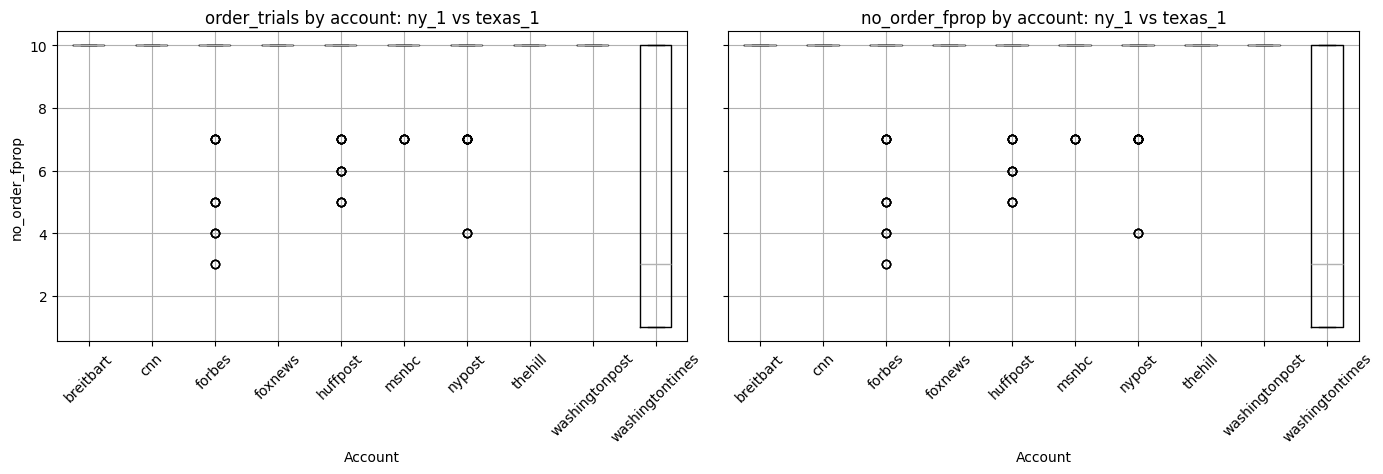

In [97]:
crawls = ['ny_1', 'texas_1']
merged_df = compute_fprops(merged_df, f'{crawls[0]}_comments', f'{crawls[1]}_comments')
# merged_df.groupby('account_name')['order_fprop'].describe()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

merged_df.boxplot(column='order_trials', by='account_name', ax=axes[0])
axes[0].set_title(f'order_trials by account: {crawls[0]} vs {crawls[1]}') 
axes[0].set_xlabel('Account')
axes[0].set_ylabel('no_order_fprop')
axes[0].tick_params(axis='x', rotation=45)

merged_df.boxplot(column='no_order_trials', by='account_name', ax=axes[1])
axes[1].set_title(f'no_order_fprop by account: {crawls[0]} vs {crawls[1]}')
axes[1].set_xlabel('Account')
axes[1].tick_params(axis='x', rotation=45)

fig.suptitle('') 
fig.tight_layout()
plt.show()

In [7]:
int_crawls = ['ny_1', 'texas_1',
              'male_dem_ny_1', 'male_dem_texas_1',
              'male_rep_ny_1', 'male_rep_texas_1',
              'female_dem_ny_1', 'female_dem_texas_1',
              'female_rep_ny_1', 'female_rep_texas_1',]
            #   'male_dem_ny_1_100925']

reg_df = pd.DataFrame(columns=['account_name', 'location', 'gender', 'ideology', 'no_order_fprop', 'no_order_fcount'])


temp_list = []
for crawl1 in ['ny_1']:
    for crawl2 in tqdm(int_crawls):

        if crawl1 == crawl2:
            continue

        temp_dict = {}

        temp_df = compute_fprops(merged_df, f'{crawl1}_comments', f'{crawl2}_comments')
        temp_df = temp_df[['url_id', 'account_name', 'no_order_trials', 'no_order_fcount']].drop_duplicates()

        location = "none"
        if 'ny' in crawl2:
            location = 'ny'
        elif 'texas' in crawl2:
            location = 'texas'

        gender = "none"
        if 'female' in crawl2:
            gender = 'female'
        elif 'male' in crawl2:
            gender = 'male'

        ideology = "none"
        if 'dem' in crawl2:
            ideology = 'dem'
        elif 'rep' in crawl2:
            ideology = 'rep'

        temp_dict['location'] = location
        temp_dict['gender'] = gender
        temp_dict['ideology'] = ideology

        for index, row in temp_df.iterrows():
            temp_dict['url_id'] = row['url_id']
            temp_dict['account_name'] = row['account_name']
            temp_dict['no_order_trials'] = row['no_order_trials']
            temp_dict['no_order_fcount'] = row['no_order_fcount']
            temp_list.append(temp_dict.copy())


reg_df = pd.DataFrame(temp_list)        
reg_df.shape

100%|██████████| 10/10 [00:00<00:00, 14.80it/s]


(900, 7)

In [8]:
reg_df.duplicated().sum()

np.int64(0)

In [9]:
accounts_data = pd.read_excel('/Users/brahmaninutakki/saarland/insta-comments/News Sites US.xlsx', sheet_name='Sheet3')
accounts_data.head(3)

,account_name,political_ideology,reporting_quality,credibility,posts,followers,following
0,msnbc,Left,Mixed,Medium,16790,2400000,308
1,huffpost,Left,Mixed,Medium,12119,3300000,708
2,cnn,Center-Left,Mostly Factual,Medium,21936,21700000,289


In [10]:
reg_df = pd.merge(reg_df, accounts_data, on='account_name', how='left')
reg_df.shape

(900, 13)

In [11]:
reg_df.head(5)

,location,gender,ideology,url_id,account_name,no_order_trials,no_order_fcount,political_ideology,reporting_quality,credibility,posts,followers,following
0,texas,none,none,DQ0AYUTkvh4,foxnews,10.0,0.0,Right,Low,Low,70290,10800000,117
1,texas,none,none,DQ0Ck-lgUxt,forbes,3.0,0.0,Center,Mostly Factual,High,27199,7300000,163
2,texas,none,none,DQ0ClEugU1r,nypost,10.0,0.0,Center-Right,Mixed,Medium,53635,2000000,317
3,texas,none,none,DQ0ClztkmYz,foxnews,10.0,0.0,Right,Low,Low,70290,10800000,117
4,texas,none,none,DQ0ETkoDtLN,nypost,10.0,1.0,Center-Right,Mixed,Medium,53635,2000000,317


In [12]:
reg_df['no_order_fcount'] = reg_df['no_order_fcount'].astype(int)
reg_df['no_order_trials'] = reg_df['no_order_trials'].astype(int)

In [13]:
reg_df[reg_df['no_order_fcount'] > reg_df['no_order_trials']]

,location,gender,ideology,url_id,account_name,no_order_trials,no_order_fcount,political_ideology,reporting_quality,credibility,posts,followers,following


In [18]:
reg_df["ideology"] = pd.Categorical(
    reg_df["ideology"],
    categories=["none", "dem", "rep"],  # 'none' first → becomes reference
    ordered=True
)
reg_df["gender"] = pd.Categorical(
    reg_df["gender"],
    categories=["none", "female", "male"],  # put 'none' first
    ordered=True
)
reg_df["location"] = pd.Categorical(
    reg_df["location"],
    categories=["ny", "texas"],
    ordered=True
)


In [53]:
political_content = pd.read_excel('/Users/brahmaninutakki/saarland/insta-comments/News Sites US.xlsx', sheet_name='Sheet5')
political_content['url_id'] = political_content['url'].apply(lambda x: x.split('/')[-2])
political_content.head()

,url,major_topic,url_id
0,https://www.instagram.com/msnbc/reel/DQz6GiKkqD-/,Political,DQz6GiKkqD-
1,https://www.instagram.com/msnbc/reel/DQzvigyiu3R/,Political,DQzvigyiu3R
2,https://www.instagram.com/msnbc/reel/DQzaxBeisq2/,Political,DQzaxBeisq2
3,https://www.instagram.com/msnbc/reel/DQzOhJyil7B/,Political,DQzOhJyil7B
4,https://www.instagram.com/msnbc/reel/DQx_MsXDdqz/,Political,DQx_MsXDdqz


In [54]:
political_content = pd.merge(political_content, merged_df[['url_id', 'account_name']], on='url_id', how='left')
political_content.head()

,url,major_topic,url_id,account_name
0,https://www.instagram.com/msnbc/reel/DQz6GiKkqD-/,Political,DQz6GiKkqD-,msnbc
1,https://www.instagram.com/msnbc/reel/DQz6GiKkqD-/,Political,DQz6GiKkqD-,msnbc
2,https://www.instagram.com/msnbc/reel/DQz6GiKkqD-/,Political,DQz6GiKkqD-,msnbc
3,https://www.instagram.com/msnbc/reel/DQz6GiKkqD-/,Political,DQz6GiKkqD-,msnbc
4,https://www.instagram.com/msnbc/reel/DQz6GiKkqD-/,Political,DQz6GiKkqD-,msnbc


In [55]:
political_content.shape

(874, 4)

In [94]:
for acc in political_content['account_name'].unique().tolist():
    polcount = political_content[political_content['account_name'] == acc]['major_topic'].value_counts().to_dict().get('Political', 0)
    nonpolcount = political_content[political_content['account_name'] == acc]['major_topic'].value_counts().to_dict().get('Non-Political', 0)

    print(f'Account: {acc}, Political: {polcount}, Non-Political: {nonpolcount}')

Account: msnbc, Political: 97, Non-Political: 0
Account: huffpost, Political: 40, Non-Political: 48
Account: cnn, Political: 50, Non-Political: 50
Account: washingtonpost, Political: 40, Non-Political: 60
Account: forbes, Political: 0, Non-Political: 79
Account: thehill, Political: 80, Non-Political: 20
Account: washingtontimes, Political: 16, Non-Political: 6
Account: nypost, Political: 30, Non-Political: 58
Account: foxnews, Political: 60, Non-Political: 40
Account: breitbart, Political: 80, Non-Political: 20


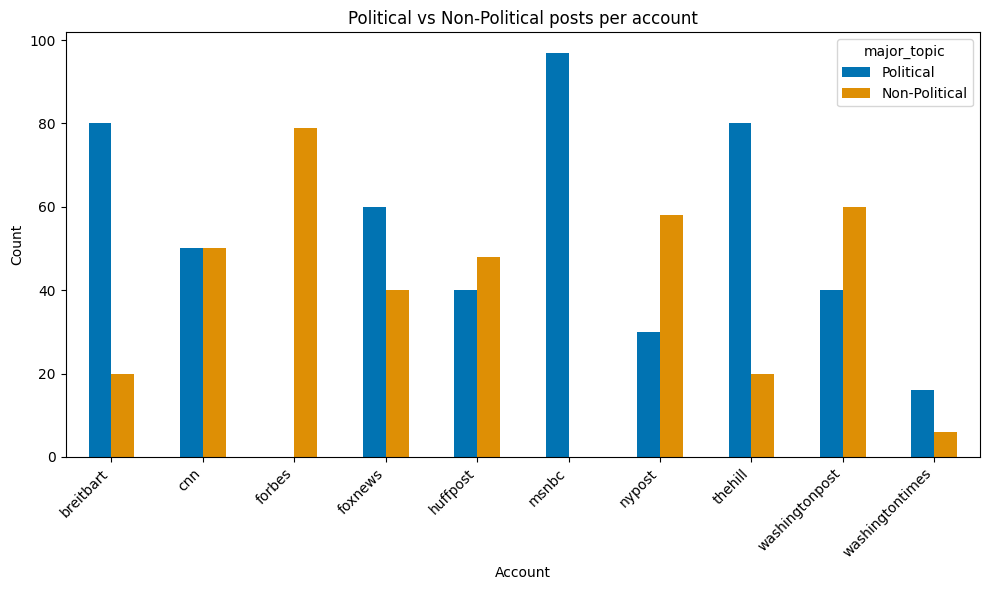

In [95]:
counts = (
    political_content
    .groupby(['account_name', 'major_topic'])
    .size()
    .unstack(fill_value=0)
)

for col in ['Political', 'Non-Political']:
    if col not in counts.columns:
        counts[col] = 0

ax = counts[['Political', 'Non-Political']].plot(
    kind='bar',
    figsize=(10, 6)
)

ax.set_xlabel('Account')
ax.set_ylabel('Count')
ax.set_title('Political vs Non-Political posts per account')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [66]:
# az.plot_posterior(results, ["Intercept", "ideology", "political_ideology", "location", "ideology:political_ideology"], hdi_prob=0.94)


### no interactions

In [98]:
reg_df

,location,gender,ideology,url_id,account_name,no_order_trials,no_order_fcount,political_ideology,reporting_quality,credibility,posts,followers,following
0,texas,none,none,DQ0AYUTkvh4,foxnews,10,0,Right,Low,Low,70290,10800000,117
1,texas,none,none,DQ0Ck-lgUxt,forbes,3,0,Center,Mostly Factual,High,27199,7300000,163
2,texas,none,none,DQ0ClEugU1r,nypost,10,0,Center-Right,Mixed,Medium,53635,2000000,317
3,texas,none,none,DQ0ClztkmYz,foxnews,10,0,Right,Low,Low,70290,10800000,117
4,texas,none,none,DQ0ETkoDtLN,nypost,10,1,Center-Right,Mixed,Medium,53635,2000000,317
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,texas,female,rep,DQzh-t0DSAJ,washingtonpost,10,2,Center-Left,Mostly Factual,High,24022,7300000,187
896,texas,female,rep,DQzkN12CUZQ,breitbart,10,3,Right,Mixed,Low,34864,1800000,362
897,texas,female,rep,DQznNr7gp1F,cnn,10,8,Center-Left,Mostly Factual,Medium,21936,21700000,289
898,texas,female,rep,DQzuD3fFJcu,washingtonpost,10,3,Center-Left,Mostly Factual,High,24022,7300000,187


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, gender, ideology, political_ideology, location, 1|account_name_sigma, 1|account_name_offset, 1|url_id_sigma, 1|url_id_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 29 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/sh/fhrqk28n1bzd27x7z4p52c940000gn/T/ipykernel_5590/3686526520.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])


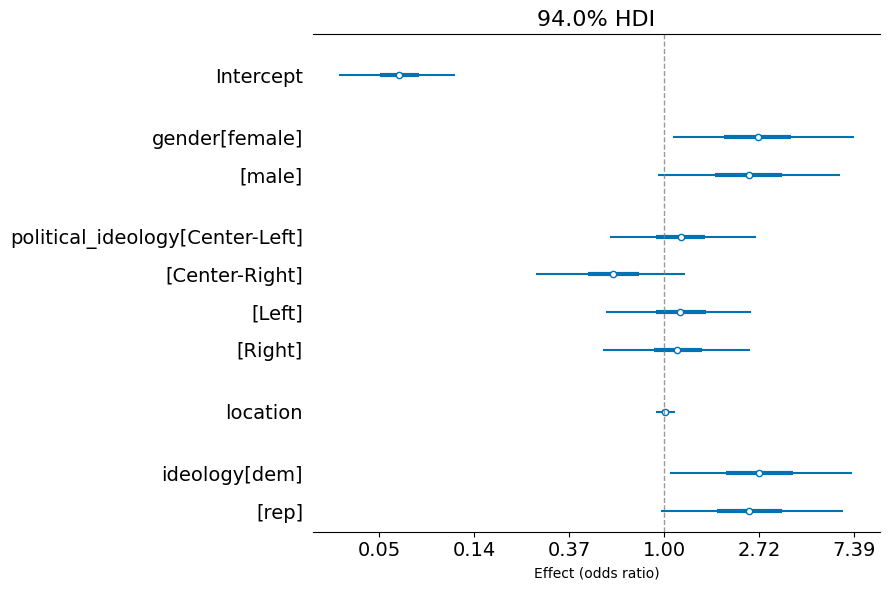

In [91]:
model = bmb.Model(
    "p(no_order_fcount, no_order_trials) ~ gender + ideology + political_ideology + location + (1|account_name) + (1|url_id)",
    data=reg_df,
    family="binomial",
)

results = model.fit(
    draws=2000,      
    tune=2000,       
    target_accept=0.95,
    chains=4
)
az.summary(results)


# az.summary(
#     results,
#     var_names=["Intercept", "gender", "political_ideology", "location", "ideology"]
# )

axes = az.plot_forest(
    results,
    var_names=["Intercept", "gender", "political_ideology", "location", "ideology"],
    combined=True,
    hdi_prob=0.94,
    figsize=(9, 6),
    r_hat=False, 
    ess=False
)

ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes

ax.axvline(0, linestyle="--", linewidth=1, color="grey", alpha=0.8)

ticks = ax.get_xticks()
ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])
ax.set_xlabel("Effect (odds ratio)")

plt.tight_layout()
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, ideology, political_ideology, location, 1|account_name_sigma, 1|account_name_offset, 1|url_id_sigma, 1|url_id_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.
/var/folders/sh/fhrqk28n1bzd27x7z4p52c940000gn/T/ipykernel_5590/1505319076.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])


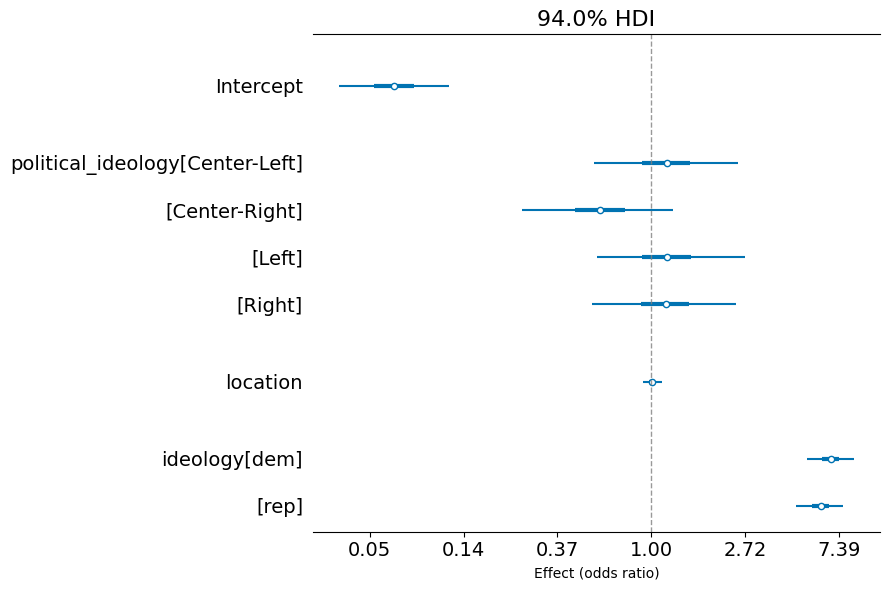

In [92]:
model = bmb.Model(
    "p(no_order_fcount, no_order_trials) ~  ideology + political_ideology + location + (1|account_name) + (1|url_id)",
    data=reg_df,
    family="binomial",
)

results = model.fit(
    draws=2000,      
    tune=2000,       
    target_accept=0.95,
    chains=4
)
az.summary(results)


# az.summary(
#     results,
#     var_names=["Intercept", "gender", "political_ideology", "location", "ideology"]
# )

axes = az.plot_forest(
    results,
    var_names=["Intercept", "political_ideology", "location", "ideology"],
    combined=True,
    hdi_prob=0.94,
    figsize=(9, 6),
    r_hat=False, 
    ess=False
)

ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes

ax.axvline(0, linestyle="--", linewidth=1, color="grey", alpha=0.8)

ticks = ax.get_xticks()
ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])
ax.set_xlabel("Effect (odds ratio)")

plt.tight_layout()
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, gender, political_ideology, location, 1|account_name_sigma, 1|account_name_offset, 1|url_id_sigma, 1|url_id_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/sh/fhrqk28n1bzd27x7z4p52c940000gn/T/ipykernel_5590/2318794822.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])


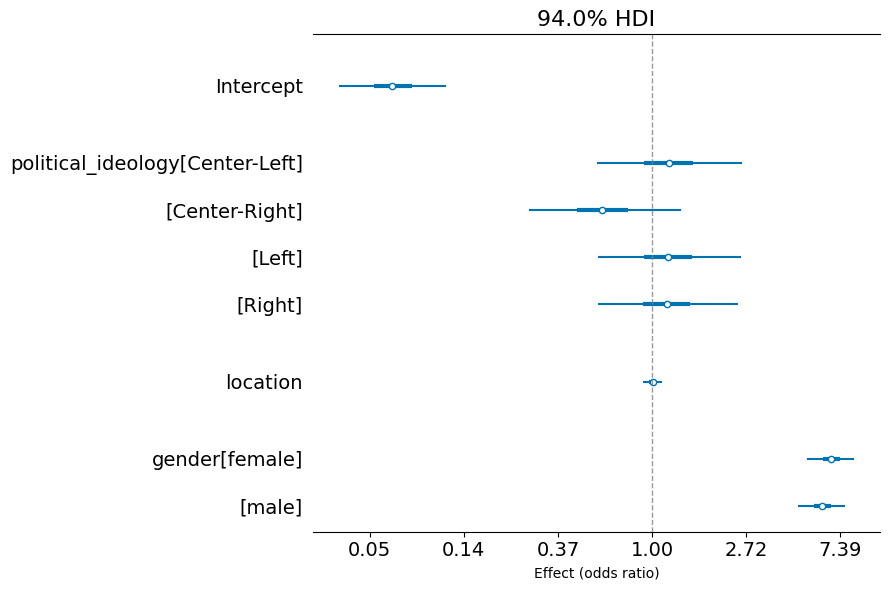

In [83]:
model = bmb.Model(
    "p(no_order_fcount, no_order_trials) ~  gender + political_ideology + location + (1|account_name) + (1|url_id)",
    data=reg_df,
    family="binomial",
)

results = model.fit(
    draws=2000,      
    tune=2000,       
    target_accept=0.95,
    chains=4
)
az.summary(results)

# az.summary(
#     results,
#     var_names=["Intercept", "gender", "political_ideology", "location", "ideology"]
# )

axes = az.plot_forest(
    results,
    var_names=["Intercept", "political_ideology", "location", "gender"],
    combined=True,
    hdi_prob=0.94,
    figsize=(9, 6),
    r_hat=False, 
    ess=False
)

ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes

ax.axvline(0, linestyle="--", linewidth=1, color="grey", alpha=0.8)

ticks = ax.get_xticks()
ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])
ax.set_xlabel("Effect (odds ratio)")

plt.tight_layout()
plt.show()

### 2 Random effects with gender 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, gender, political_ideology, gender:political_ideology, location, 1|account_name_sigma, 1|account_name_offset, 1|url_id_sigma, 1|url_id_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/sh/fhrqk28n1bzd27x7z4p52c940000gn/T/ipykernel_5590/129808597.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])


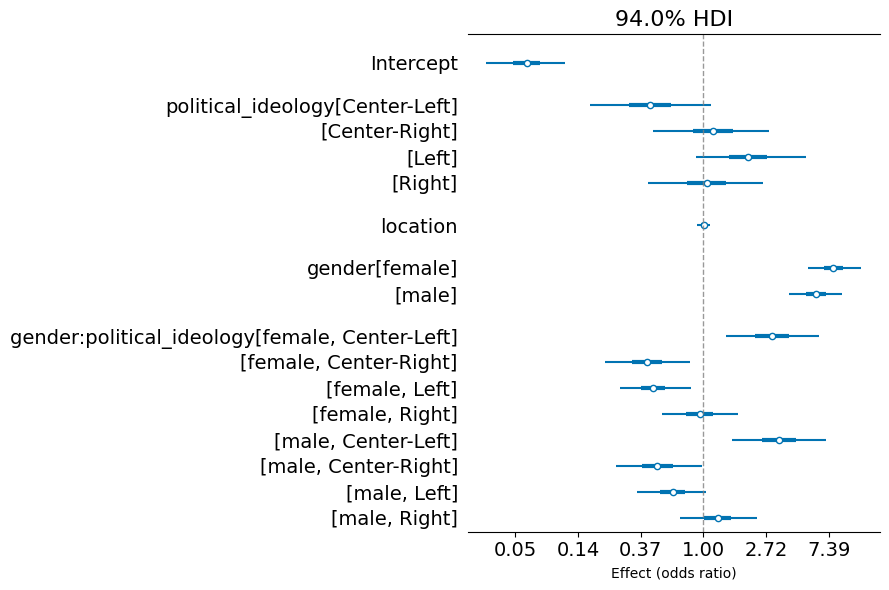

In [84]:
model = bmb.Model(
    "p(no_order_fcount, no_order_trials) ~ gender * political_ideology + location + (1|account_name) + (1|url_id)",
    data=reg_df,
    family="binomial",
)

results = model.fit(
    draws=2000,      
    tune=2000,       
    target_accept=0.95,
    chains=4
)
az.summary(results)


# az.summary(
#     results,
#     var_names=["Intercept", "gender", "political_ideology", "location", "ideology"]
# )

axes = az.plot_forest(
    results,
    var_names=["Intercept", "political_ideology", "location", "gender", "gender:political_ideology"],
    combined=True,
    hdi_prob=0.94,
    figsize=(9, 6),
    r_hat=False, 
    ess=False
)

ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes

ax.axvline(0, linestyle="--", linewidth=1, color="grey", alpha=0.8)

ticks = ax.get_xticks()
ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])
ax.set_xlabel("Effect (odds ratio)")

plt.tight_layout()
plt.show()

### 2 Random effects with ideology

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, ideology, political_ideology, ideology:political_ideology, location, 1|account_name_sigma, 1|account_name_offset, 1|url_id_sigma, 1|url_id_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
/var/folders/sh/fhrqk28n1bzd27x7z4p52c940000gn/T/ipykernel_5590/1638284921.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])


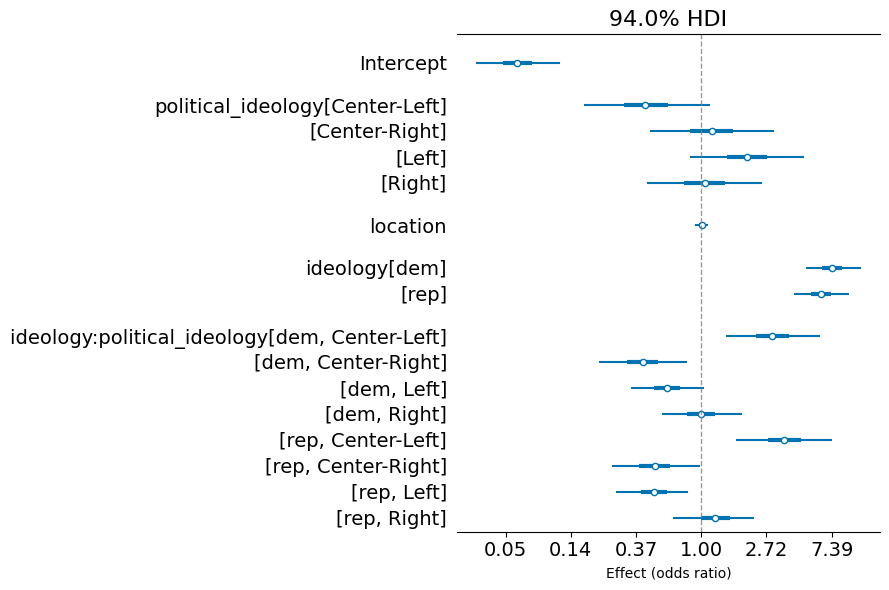

In [85]:
model = bmb.Model(
    "p(no_order_fcount, no_order_trials) ~ ideology * political_ideology + location + (1|account_name) + (1|url_id)",
    data=reg_df,
    family="binomial",
)

results = model.fit(
    draws=2000,      
    tune=2000,       
    target_accept=0.95,
    chains=4
)
az.summary(results)


# az.summary(
#     results,
#     var_names=["Intercept", "gender", "political_ideology", "location", "ideology"]
# )

axes = az.plot_forest(
    results,
    var_names=["Intercept", "political_ideology", "location", "ideology", "ideology:political_ideology"],
    combined=True,
    hdi_prob=0.94,
    figsize=(9, 6),
    r_hat=False, 
    ess=False
)

ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes

ax.axvline(0, linestyle="--", linewidth=1, color="grey", alpha=0.8)

ticks = ax.get_xticks()
ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])
ax.set_xlabel("Effect (odds ratio)")

plt.tight_layout()
plt.show()

### 1 Random effect with gender

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, gender, political_ideology, gender:political_ideology, location, account_name, 1|url_id_sigma, 1|url_id_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.
/var/folders/sh/fhrqk28n1bzd27x7z4p52c940000gn/T/ipykernel_5590/1110102045.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])


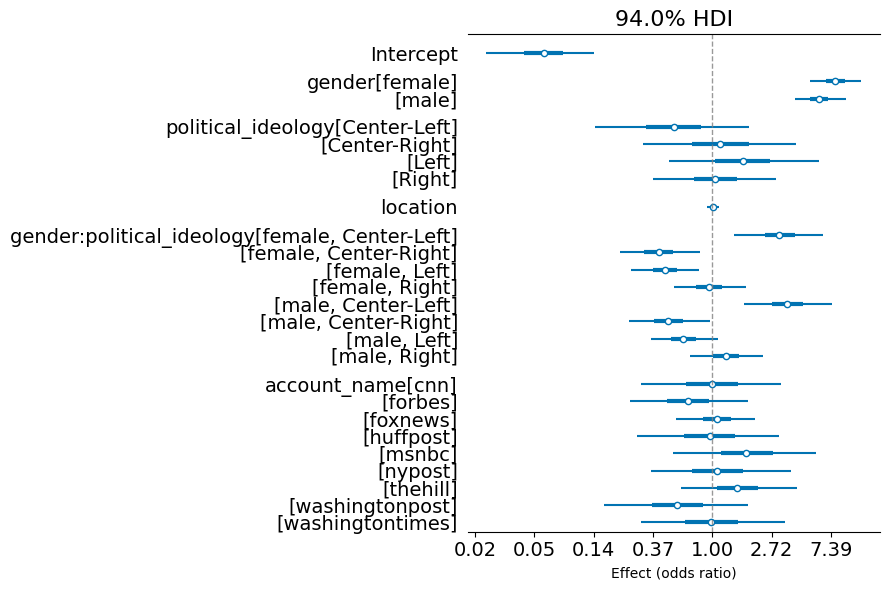

In [86]:
model = bmb.Model(
    "p(no_order_fcount, no_order_trials) ~ gender * political_ideology + location + account_name + (1|url_id)",
    data=reg_df,
    family="binomial",
)

results = model.fit(
    draws=2000,      
    tune=2000,       
    target_accept=0.95,
    chains=4
)
az.summary(results)

axes = az.plot_forest(
    results,
    var_names=["Intercept", "gender", "political_ideology", "location", "gender:political_ideology", "account_name"],
    combined=True,
    hdi_prob=0.94,
    figsize=(9, 6),
    r_hat=False, 
    ess=False
)

ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes

ax.axvline(0, linestyle="--", linewidth=1, color="grey", alpha=0.8)

ticks = ax.get_xticks()
ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])
ax.set_xlabel("Effect (odds ratio)")

plt.tight_layout()
plt.show()


### 1 Random effects with ideology

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, ideology, political_ideology, ideology:political_ideology, location, account_name, 1|url_id_sigma, 1|url_id_offset]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 23 seconds.
/var/folders/sh/fhrqk28n1bzd27x7z4p52c940000gn/T/ipykernel_5590/1666748822.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])


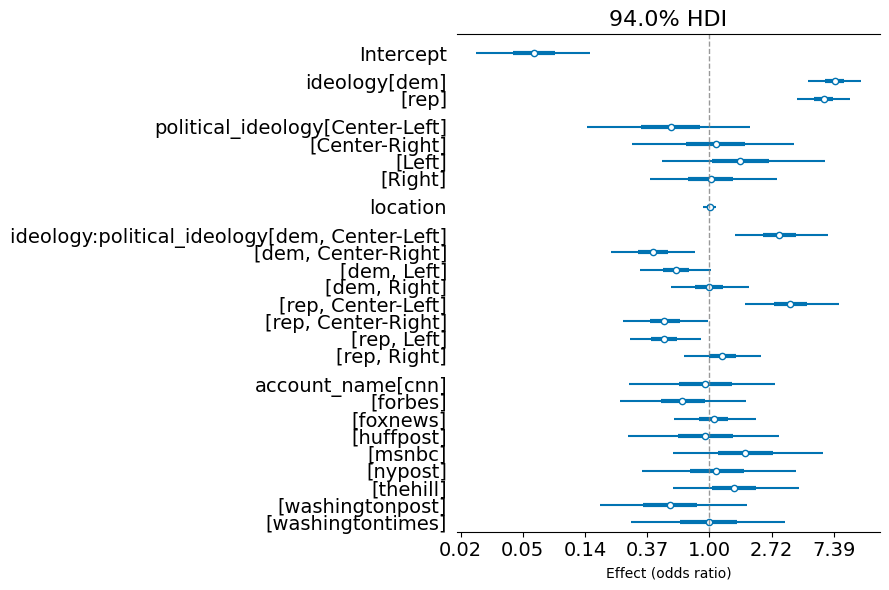

In [87]:
model = bmb.Model(
    "p(no_order_fcount, no_order_trials) ~ ideology * political_ideology + location + account_name + (1|url_id)",
    data=reg_df,
    family="binomial",
)

results = model.fit(
    draws=2000,      
    tune=2000,       
    target_accept=0.95,
    chains=4
)
az.summary(results)

axes = az.plot_forest(
    results,
    var_names=["Intercept", "ideology", "political_ideology", "location", "ideology:political_ideology", "account_name"],
    combined=True,
    hdi_prob=0.94,
    figsize=(9, 6),
    r_hat=False, 
    ess=False
)

ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes

ax.axvline(0, linestyle="--", linewidth=1, color="grey", alpha=0.8)

ticks = ax.get_xticks()
ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])
ax.set_xlabel("Effect (odds ratio)")

plt.tight_layout()
plt.show()


### gender and ideology


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, ideology, gender, ideology:gender, political_ideology, location, 1|account_name_sigma, 1|account_name_offset, 1|url_id_sigma, 1|url_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/var/folders/sh/fhrqk28n1bzd27x7z4p52c940000gn/T/ipykernel_5590/4051521647.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])


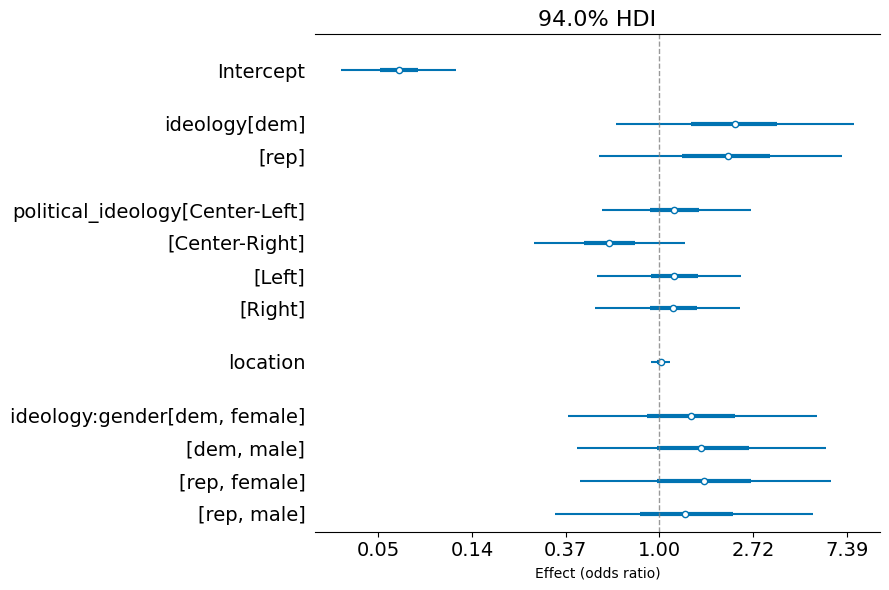

In [90]:
model = bmb.Model(
    "p(no_order_fcount, no_order_trials) ~ ideology*gender + political_ideology + location + (1|account_name) + (1|url_id)",
    data=reg_df,
    family="binomial",
)

results = model.fit()
az.summary(results)

axes = az.plot_forest(
    results,
    var_names=["Intercept", "ideology", "political_ideology", "location", "ideology:gender"],
    combined=True,
    hdi_prob=0.94,
    figsize=(9, 6),
    r_hat=False, 
    ess=False
)

ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes

ax.axvline(0, linestyle="--", linewidth=1, color="grey", alpha=0.8)

ticks = ax.get_xticks()
ax.set_xticklabels([f"{np.exp(t):.2f}" for t in ticks])
ax.set_xlabel("Effect (odds ratio)")

plt.tight_layout()
plt.show()